# Heterogeneous Data Experiments

Test symmetry regularization with data heterogeneity:

## Experiment 1: Multiple Perturbation Distributions (One Animal)
- **Same decoder** (observation matrix C)
- **Different perturbation directions** (different random perturbation matrices)
- Same perturbation magnitude
- Pool all trajectories together

## Experiment 2: Multi-Animal Setting
- **Different decoders** (observation matrices) per animal
- Same underlying ring attractor
- Pool trajectories from all animals

In [28]:
# Setup
import sys
sys.path.append('../..')

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

import xfads.utils as utils
import xfads.plot_utils as plot_utils
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import GaussianLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.nonlinear_smoother import NonlinearFilterSmallL

from regularized_ssm import RegularizedSSM, create_rotation_vector_field

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cpu


In [29]:
# Config
class Config:
    n_latents = 2
    n_latents_read = 2
    n_hidden_dynamics = 32
    n_hidden_local = 32
    n_hidden_backward = 32
    rank_local = 2
    rank_backward = 2
    p_local_dropout = 0.0
    
    n_samples = 5
    batch_sz = 32
    learning_rate = 1e-3
    max_epochs = 30
    patience = 7
    grad_clip = 1.0
    
    # Data parameters
    n_trials_per_condition = 250  # Per perturbation or per animal
    n_neurons = 100
    n_time_bins = 75
    train_split = 0.8
    
    # Experiment 1: Multiple perturbations (one animal)
    n_perturbations = 4  # Number of different perturbation directions
    perturbation_magnitude = 0.15
    
    # Experiment 2: Multi-animal
    n_animals = 4
    
    # Regularization
    lambda_lie = 1e-4
    
    seed = SEED

cfg = Config()
print(f"Experiment 1: {cfg.n_perturbations} perturbation distributions, {cfg.n_trials_per_condition} trials each")
print(f"Experiment 2: {cfg.n_animals} animals, {cfg.n_trials_per_condition} trials each")
print(f"Lambda: {cfg.lambda_lie}")

Experiment 1: 4 perturbation distributions, 250 trials each
Experiment 2: 4 animals, 250 trials each
Lambda: 0.0001


In [30]:
# Load ring attractor
import importlib.util

spec = importlib.util.spec_from_file_location("test_dynamics", "test_dynamics.py")
test_dynamics = importlib.util.module_from_spec(spec)
spec.loader.exec_module(test_dynamics)
PerturbedRingAttractorDynamics = test_dynamics.PerturbedRingAttractorRNN

target_rotation_field = create_rotation_vector_field(rotation_speed=0.5)
print("Ring attractor dynamics loaded")

Ring attractor dynamics loaded


---
# Experiment 1: Multiple Perturbation Distributions (One Animal)

Same decoder, different perturbation directions

In [31]:
print("=" * 60)
print("EXPERIMENT 1: Multiple Perturbation Distributions")
print("=" * 60)

# Create ONE observation matrix (same decoder)
C_exp1 = utils.FanInLinear(cfg.n_latents, cfg.n_neurons, device=device).requires_grad_(False)
Q_diag = 5e-3 * torch.ones(cfg.n_latents, device=device)
Q_0_diag = 1.0 * torch.ones(cfg.n_latents, device=device)
R_diag = 1e-1 * torch.ones(cfg.n_neurons, device=device)
m_0 = torch.zeros(cfg.n_latents, device=device)

# Generate data from MULTIPLE perturbation distributions
z_all = []
y_all = []

print(f"\nGenerating data from {cfg.n_perturbations} different perturbation distributions...")
for i in range(cfg.n_perturbations):
    # Create ring attractor with DIFFERENT perturbation (different random seed)
    torch.manual_seed(SEED + i * 1000)  # Different seed = different perturbation direction
    
    dynamics = PerturbedRingAttractorDynamics(
        bin_sz=1e-1,
        lengthscale=0.2,
        perturbation_magnitude=cfg.perturbation_magnitude
    ).to(device)
    
    # Generate trajectories
    z = utils.sample_gauss_z(dynamics, Q_diag, m_0, Q_0_diag, 
                            cfg.n_trials_per_condition, cfg.n_time_bins)
    y = C_exp1(z) + torch.sqrt(R_diag) * torch.randn(
        (cfg.n_trials_per_condition, cfg.n_time_bins, cfg.n_neurons), device=device)
    
    z_all.append(z)
    y_all.append(y)
    
    print(f"  Perturbation {i+1}: {cfg.n_trials_per_condition} trials")

# Pool all data together
z_exp1 = torch.cat(z_all, dim=0).detach()
y_exp1 = torch.cat(y_all, dim=0).detach()

# Shuffle
torch.manual_seed(SEED)
shuffle_idx = torch.randperm(y_exp1.shape[0])
z_exp1 = z_exp1[shuffle_idx]
y_exp1 = y_exp1[shuffle_idx]

n_train_exp1 = int(cfg.train_split * y_exp1.shape[0])
y_train_exp1 = y_exp1[:n_train_exp1]
y_valid_exp1 = y_exp1[n_train_exp1:]

print(f"\n✅ Experiment 1 data ready:")
print(f"   Total: {y_exp1.shape[0]} trials (pooled from {cfg.n_perturbations} perturbations)")
print(f"   Train: {y_train_exp1.shape[0]} trials")
print(f"   Valid: {y_valid_exp1.shape[0]} trials")
print(f"   Same decoder for all!")

EXPERIMENT 1: Multiple Perturbation Distributions

Generating data from 4 different perturbation distributions...
  Perturbation 1: 250 trials
  Perturbation 2: 250 trials
  Perturbation 3: 250 trials
  Perturbation 4: 250 trials

✅ Experiment 1 data ready:
   Total: 1000 trials (pooled from 4 perturbations)
   Train: 800 trials
   Valid: 200 trials
   Same decoder for all!


---
# Experiment 2: Multi-Animal Setting

Different decoders per animal

In [32]:
print("\n" + "=" * 60)
print("EXPERIMENT 2: Multi-Animal Setting")
print("=" * 60)

# Create DIFFERENT observation matrices per animal
C_animals = []
for i in range(cfg.n_animals):
    torch.manual_seed(SEED + i * 100)
    C = utils.FanInLinear(cfg.n_latents, cfg.n_neurons, device=device).requires_grad_(False)
    C_animals.append(C)

# Use SAME underlying dynamics (one perturbation)
torch.manual_seed(SEED)
dynamics_exp2 = PerturbedRingAttractorDynamics(
    bin_sz=1e-1,
    lengthscale=0.2,
    perturbation_magnitude=cfg.perturbation_magnitude
).to(device)

# Generate data for each animal
z_all_animals = []
y_all_animals = []

print(f"\nGenerating data from {cfg.n_animals} different animals...")
for i in range(cfg.n_animals):
    # Same dynamics, different observation matrix
    z = utils.sample_gauss_z(dynamics_exp2, Q_diag, m_0, Q_0_diag,
                            cfg.n_trials_per_condition, cfg.n_time_bins)
    y = C_animals[i](z) + torch.sqrt(R_diag) * torch.randn(
        (cfg.n_trials_per_condition, cfg.n_time_bins, cfg.n_neurons), device=device)
    
    z_all_animals.append(z)
    y_all_animals.append(y)
    
    print(f"  Animal {i+1}: {cfg.n_trials_per_condition} trials (unique decoder)")

# Pool all data together
z_exp2 = torch.cat(z_all_animals, dim=0).detach()
y_exp2 = torch.cat(y_all_animals, dim=0).detach()

# Shuffle
torch.manual_seed(SEED)
shuffle_idx = torch.randperm(y_exp2.shape[0])
z_exp2 = z_exp2[shuffle_idx]
y_exp2 = y_exp2[shuffle_idx]

n_train_exp2 = int(cfg.train_split * y_exp2.shape[0])
y_train_exp2 = y_exp2[:n_train_exp2]
y_valid_exp2 = y_exp2[n_train_exp2:]

print(f"\n✅ Experiment 2 data ready:")
print(f"   Total: {y_exp2.shape[0]} trials (pooled from {cfg.n_animals} animals)")
print(f"   Train: {y_train_exp2.shape[0]} trials")
print(f"   Valid: {y_valid_exp2.shape[0]} trials")
print(f"   Different decoder for each animal!")


EXPERIMENT 2: Multi-Animal Setting

Generating data from 4 different animals...
  Animal 1: 250 trials (unique decoder)
  Animal 2: 250 trials (unique decoder)
  Animal 3: 250 trials (unique decoder)
  Animal 4: 250 trials (unique decoder)

✅ Experiment 2 data ready:
   Total: 1000 trials (pooled from 4 animals)
   Train: 800 trials
   Valid: 200 trials
   Different decoder for each animal!


In [33]:
# Model factory
def create_ssm(lambda_lie, C_matrix):
    """Create SSM with specified observation matrix."""
    H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
    readout_fn = nn.Sequential(H, C_matrix)
    likelihood_pdf = GaussianLikelihood(readout_fn, cfg.n_neurons, R_diag, device=device, fix_R=True)

    dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=device)
    dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=device)

    initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=device)

    backward_encoder = BackwardEncoderLRMvn(
        cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
        rank_local=cfg.rank_local, rank_backward=cfg.rank_backward, device=device
    )
    local_encoder = LocalEncoderLRMvn(
        cfg.n_latents, cfg.n_neurons, cfg.n_hidden_local, cfg.n_latents,
        rank=cfg.rank_local, device=device, dropout=cfg.p_local_dropout
    )

    nl_filter = NonlinearFilterSmallL(dynamics_mod, initial_condition_pdf, device=device)

    ssm = RegularizedSSM(
        dynamics_mod=dynamics_mod,
        likelihood_pdf=likelihood_pdf,
        initial_c_pdf=initial_condition_pdf,
        backward_encoder=backward_encoder,
        local_encoder=local_encoder,
        nl_filter=nl_filter,
        target_vector_field=target_rotation_field if lambda_lie > 0 else None,
        lambda_lie=lambda_lie,
        lambda_curvature=0.0,
        lie_normalize="yang" if lambda_lie > 0 else None,
        device=device
    )
    return ssm

# Training function
def train_model(ssm, y_train, y_valid, name="model"):
    optimizer = torch.optim.Adam(ssm.parameters(), lr=cfg.learning_rate)
    
    best_valid_elbo = float('inf')
    patience_counter = 0
    best_model_state = None
    
    print(f"Training {name}...")
    for epoch in range(1, cfg.max_epochs + 1):
        ssm.train()
        train_losses = []
        indices = torch.randperm(len(y_train))
        
        for i in range(0, len(y_train), cfg.batch_sz):
            batch_indices = indices[i:i+cfg.batch_sz]
            y_batch = y_train[batch_indices]
            
            optimizer.zero_grad()
            total_loss, _, stats = ssm(y_batch, cfg.n_samples)
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(ssm.parameters(), cfg.grad_clip)
            optimizer.step()
            
            train_losses.append(stats)
        
        ssm.eval()
        with torch.no_grad():
            valid_total_loss, _, valid_stats = ssm(y_valid, cfg.n_samples)
        
        current_valid_elbo = valid_stats['elbo_loss'].item()
        
        if current_valid_elbo < best_valid_elbo:
            best_valid_elbo = current_valid_elbo
            patience_counter = 0
            best_model_state = {k: v.cpu() for k, v in ssm.state_dict().items()}
        else:
            patience_counter += 1
        
        if epoch % 5 == 0:
            print(f"  Epoch {epoch}: Valid ELBO = {current_valid_elbo:.3f}, Patience = {patience_counter}/{cfg.patience}")
        
        if patience_counter >= cfg.patience:
            print(f"  Early stopping at epoch {epoch}")
            break
    
    if best_model_state is not None:
        ssm.load_state_dict(best_model_state)
    
    # Compute final stats on validation set
    ssm.eval()
    with torch.no_grad():
        _, _, final_stats = ssm(y_valid, cfg.n_samples)
    
    results = {
        'elbo': final_stats['elbo_loss'].item(),
        'lie_loss': final_stats.get('lie_loss', torch.tensor(0.0)).item(),
        'kl_loss': final_stats.get('kl_loss', torch.tensor(0.0)).item(),
        'recon_loss': final_stats.get('recon_loss', torch.tensor(0.0)).item(),
    }
    
    print(f"  Final Valid ELBO: {results['elbo']:.3f}, Lie Loss: {results['lie_loss']:.4f}")
    
    return results

print("Model and training functions ready")

Model and training functions ready


---
# Run Experiment 1

In [34]:
print("\n" + "=" * 60)
print("Training Experiment 1: Multiple Perturbations")
print("=" * 60)

# Baseline
torch.manual_seed(SEED)
ssm_exp1_baseline = create_ssm(lambda_lie=0.0, C_matrix=C_exp1)
stats_exp1_baseline = train_model(ssm_exp1_baseline, y_train_exp1, y_valid_exp1, "Exp1 Baseline")

# Regularized
torch.manual_seed(SEED)
ssm_exp1_reg = create_ssm(lambda_lie=cfg.lambda_lie, C_matrix=C_exp1)
stats_exp1_reg = train_model(ssm_exp1_reg, y_train_exp1, y_valid_exp1, "Exp1 Regularized")

print(f"\n📊 Experiment 1 Results:")
print(f"   Baseline:")
print(f"     ELBO: {stats_exp1_baseline['elbo']:.3f}")
print(f"     Lie Loss: {stats_exp1_baseline['lie_loss']:.4f}")
print(f"   Regularized:")
print(f"     ELBO: {stats_exp1_reg['elbo']:.3f}")
print(f"     Lie Loss: {stats_exp1_reg['lie_loss']:.4f}")
print(f"   Improvement: {stats_exp1_baseline['elbo'] - stats_exp1_reg['elbo']:.3f}")


Training Experiment 1: Multiple Perturbations
Training Exp1 Baseline...
  Epoch 5: Valid ELBO = 10867.929, Patience = 0/7
  Epoch 10: Valid ELBO = 2667.403, Patience = 0/7
  Epoch 15: Valid ELBO = 2472.679, Patience = 0/7
  Epoch 20: Valid ELBO = 2388.331, Patience = 0/7
  Epoch 25: Valid ELBO = 2330.630, Patience = 0/7
  Epoch 30: Valid ELBO = 2315.477, Patience = 0/7
  Final Valid ELBO: 2315.338, Lie Loss: 0.0000
Training Exp1 Regularized...
  Epoch 5: Valid ELBO = 12932.110, Patience = 0/7
  Epoch 10: Valid ELBO = 2622.486, Patience = 0/7
  Epoch 15: Valid ELBO = 2431.663, Patience = 0/7
  Epoch 20: Valid ELBO = 2360.888, Patience = 0/7
  Epoch 25: Valid ELBO = 2319.839, Patience = 0/7
  Epoch 30: Valid ELBO = 2312.424, Patience = 0/7
  Final Valid ELBO: 2310.906, Lie Loss: 11.9972

📊 Experiment 1 Results:
   Baseline:
     ELBO: 2315.338
     Lie Loss: 0.0000
   Regularized:
     ELBO: 2310.906
     Lie Loss: 11.9972
   Improvement: 4.432


---
# Run Experiment 2

In [ ]:
print("\n" + "=" * 60)
print("Training Experiment 2: Multi-Animal")
print("=" * 60)

# Use first animal's C matrix (or could average, but simplest is to pick one)
C_exp2 = C_animals[0]

# Baseline
torch.manual_seed(SEED)
ssm_exp2_baseline = create_ssm(lambda_lie=0.0, C_matrix=C_exp2)
stats_exp2_baseline = train_model(ssm_exp2_baseline, y_train_exp2, y_valid_exp2, "Exp2 Baseline")

# Regularized
torch.manual_seed(SEED)
ssm_exp2_reg = create_ssm(lambda_lie=cfg.lambda_lie, C_matrix=C_exp2)
stats_exp2_reg = train_model(ssm_exp2_reg, y_train_exp2, y_valid_exp2, "Exp2 Regularized")

print(f"\n📊 Experiment 2 Results:")
print(f"   Baseline:")
print(f"     ELBO: {stats_exp2_baseline['elbo']:.3f}")
print(f"     Lie Loss: {stats_exp2_baseline['lie_loss']:.4f}")
print(f"   Regularized:")
print(f"     ELBO: {stats_exp2_reg['elbo']:.3f}")
print(f"     Lie Loss: {stats_exp2_reg['lie_loss']:.4f}")
print(f"   Improvement: {stats_exp2_baseline['elbo'] - stats_exp2_reg['elbo']:.3f}")


Training Experiment 2: Multi-Animal
Training Exp2 Baseline...
  Epoch 5: Valid ELBO = 22799.795, Patience = 0/7
  Epoch 10: Valid ELBO = 19211.523, Patience = 0/7
  Epoch 15: Valid ELBO = 19013.529, Patience = 0/7
  Epoch 20: Valid ELBO = 18957.832, Patience = 0/7
  Epoch 25: Valid ELBO = 18912.721, Patience = 0/7
  Epoch 30: Valid ELBO = 18887.645, Patience = 0/7
  Final Valid ELBO: 18890.355, Lie Loss: 0.0000
Training Exp2 Regularized...
  Epoch 5: Valid ELBO = 23569.574, Patience = 0/7
  Epoch 10: Valid ELBO = 20665.426, Patience = 0/7
  Epoch 15: Valid ELBO = 19030.236, Patience = 0/7
  Epoch 20: Valid ELBO = 18958.369, Patience = 0/7
  Epoch 25: Valid ELBO = 18920.439, Patience = 0/7
  Epoch 30: Valid ELBO = 18893.105, Patience = 0/7
  Final Valid ELBO: 18897.189, Lie Loss: 150.0205

📊 Experiment 2 Results:
   Baseline:
     ELBO: 18890.355
     Lie Loss: 0.0000
   Regularized:
     ELBO: 18897.189
     Lie Loss: 150.0205
   Improvement: -6.834


---
# Visualize Results

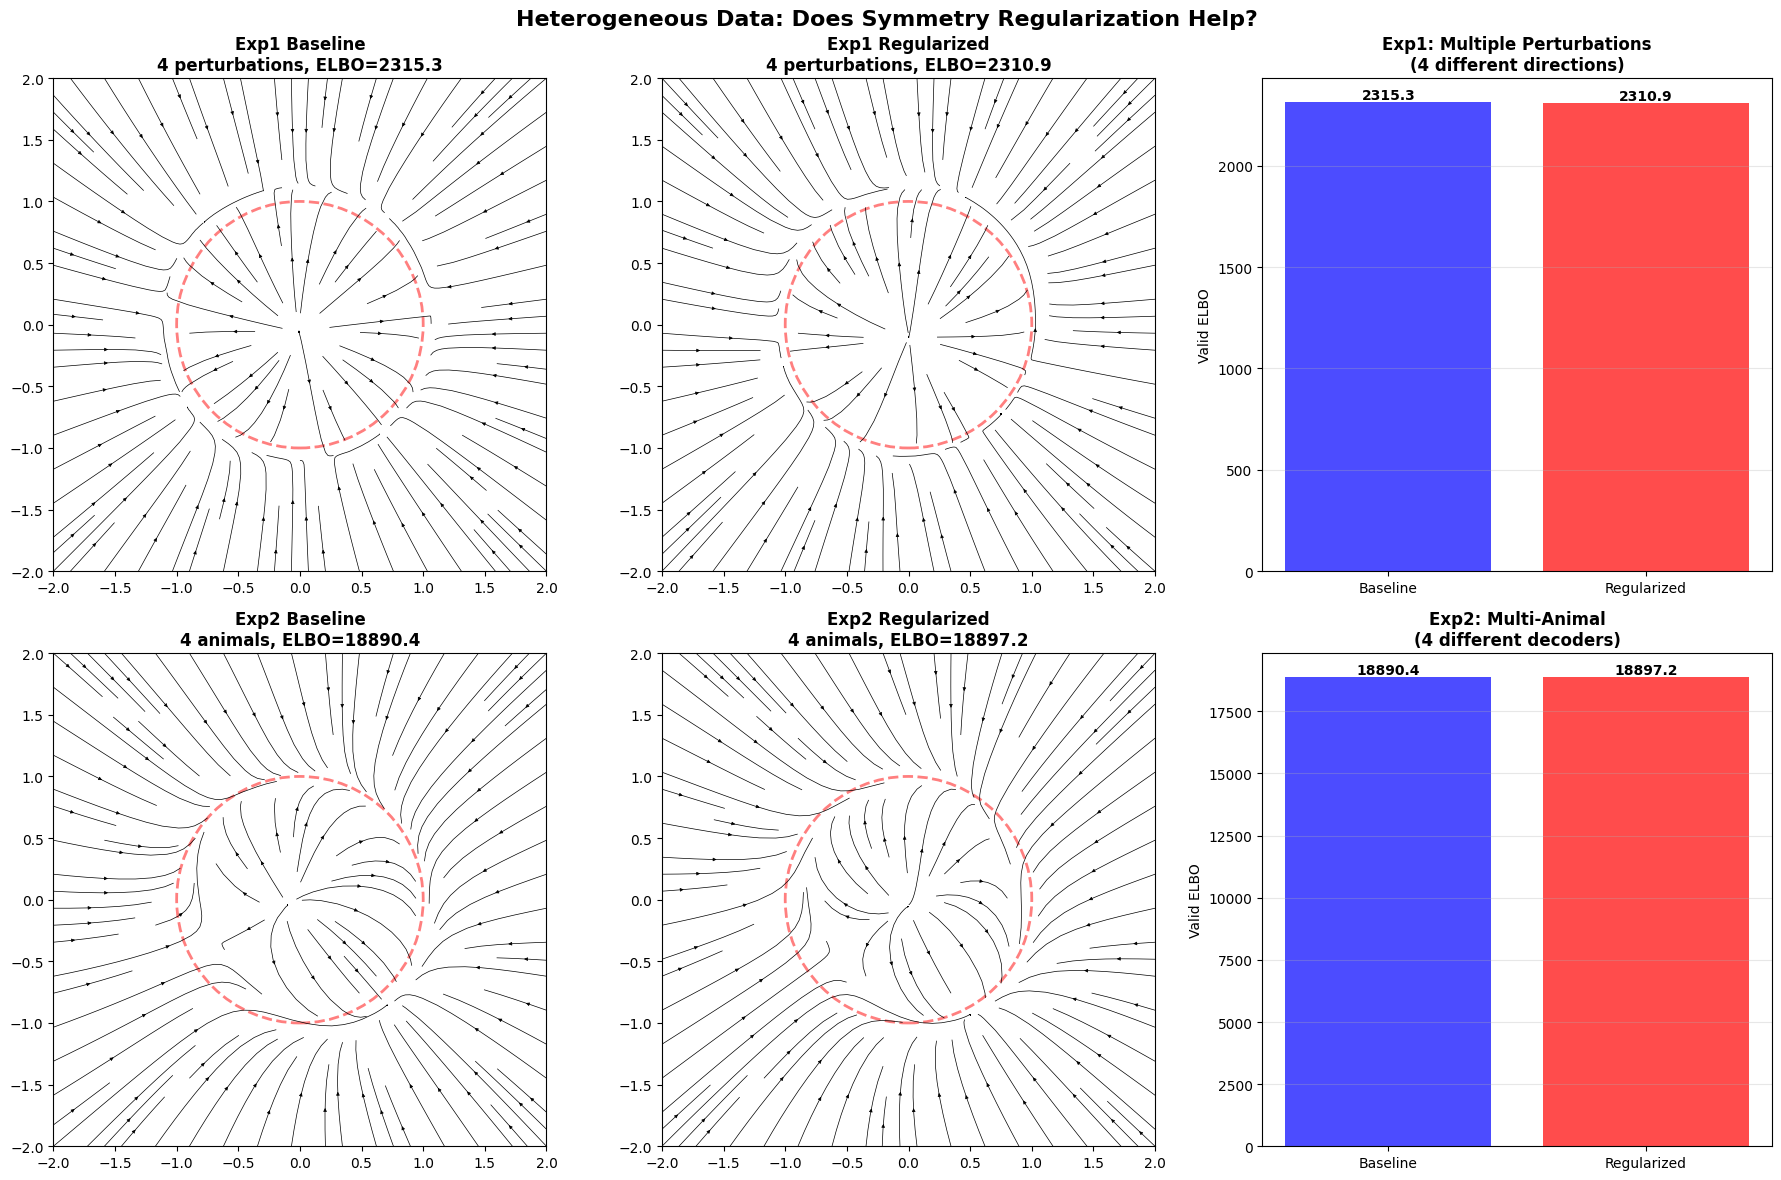


✅ Saved: heterogeneous_data_results.png


In [36]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Exp 1: Baseline
ax = axes[0, 0]
ssm_exp1_baseline.eval()
plot_utils.plot_two_d_vector_field(ssm_exp1_baseline.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.add_patch(circle)
ax.set_title(f'Exp1 Baseline\n{cfg.n_perturbations} perturbations, ELBO={stats_exp1_baseline["elbo"]:.1f}', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# Exp 1: Regularized
ax = axes[0, 1]
ssm_exp1_reg.eval()
plot_utils.plot_two_d_vector_field(ssm_exp1_reg.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.add_patch(circle)
ax.set_title(f'Exp1 Regularized\n{cfg.n_perturbations} perturbations, ELBO={stats_exp1_reg["elbo"]:.1f}', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# Exp 1: ELBO comparison
ax = axes[0, 2]
bars = ax.bar(['Baseline', 'Regularized'], [stats_exp1_baseline['elbo'], stats_exp1_reg['elbo']],
              color=['blue', 'red'], alpha=0.7)
ax.set_ylabel('Valid ELBO')
ax.set_title(f'Exp1: Multiple Perturbations\n({cfg.n_perturbations} different directions)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# Exp 2: Baseline
ax = axes[1, 0]
ssm_exp2_baseline.eval()
plot_utils.plot_two_d_vector_field(ssm_exp2_baseline.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.add_patch(circle)
ax.set_title(f'Exp2 Baseline\n{cfg.n_animals} animals, ELBO={stats_exp2_baseline["elbo"]:.1f}', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# Exp 2: Regularized
ax = axes[1, 1]
ssm_exp2_reg.eval()
plot_utils.plot_two_d_vector_field(ssm_exp2_reg.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.add_patch(circle)
ax.set_title(f'Exp2 Regularized\n{cfg.n_animals} animals, ELBO={stats_exp2_reg["elbo"]:.1f}', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# Exp 2: ELBO comparison
ax = axes[1, 2]
bars = ax.bar(['Baseline', 'Regularized'], [stats_exp2_baseline['elbo'], stats_exp2_reg['elbo']],
              color=['blue', 'red'], alpha=0.7)
ax.set_ylabel('Valid ELBO')
ax.set_title(f'Exp2: Multi-Animal\n({cfg.n_animals} different decoders)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Heterogeneous Data: Does Symmetry Regularization Help?', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('heterogeneous_data_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: heterogeneous_data_results.png")

---
# Experiment 3: Independent vs Pooled Models

**Key Question**: When you have multi-animal data with different decoders, which modeling strategy is better?

**Comparison**:
1. **Pooled models** (from Exp 2): 1 model, wrong decoder for 3/4 animals, 1000 trials
2. **Independent models** (new): 4 separate models, correct decoder each, 250 trials per model

**Hypothesis**: 
- Pooled models suffer from decoder mismatch
- Independent models have correct architecture but limited data
- Regularization helps both scenarios by providing inductive bias

In [38]:
print("\n" + "=" * 60)
print("EXPERIMENT 3: Independent Models per Animal")
print("=" * 60)

# Split data per animal (recall: y_all_animals[i] contains data for animal i)
# We already have separate datasets per animal from Experiment 2
print(f"\nPreparing independent training for {cfg.n_animals} animals...")
print(f"Each animal gets {cfg.n_trials_per_condition} trials")

# Split each animal's data into train/valid
y_train_per_animal = []
y_valid_per_animal = []

for i in range(cfg.n_animals):
    n_train_animal = int(cfg.train_split * cfg.n_trials_per_condition)
    y_train_per_animal.append(y_all_animals[i][:n_train_animal])
    y_valid_per_animal.append(y_all_animals[i][n_train_animal:])
    print(f"  Animal {i+1}: {len(y_train_per_animal[i])} train, {len(y_valid_per_animal[i])} valid")

print(f"\n✅ Data split ready for independent model training")


EXPERIMENT 3: Independent Models per Animal

Preparing independent training for 4 animals...
Each animal gets 250 trials
  Animal 1: 200 train, 50 valid
  Animal 2: 200 train, 50 valid
  Animal 3: 200 train, 50 valid
  Animal 4: 200 train, 50 valid

✅ Data split ready for independent model training


In [43]:
print("\n" + "Training Independent Models (Baseline)...")
print("=" * 60)

# Train separate model for each animal (baseline, no regularization)
ssm_indep_baseline = []
stats_indep_baseline = []

for i in range(cfg.n_animals):
    print(f"\n🐁 Animal {i+1}/{cfg.n_animals}")
    torch.manual_seed(SEED + i)  # Different seed per animal
    
    # Create model with CORRECT decoder for this animal
    ssm = create_ssm(lambda_lie=0.0, C_matrix=C_animals[i])
    stats = train_model(ssm, y_train_per_animal[i], y_valid_per_animal[i], 
                       f"Animal {i+1} Baseline")
    
    ssm_indep_baseline.append(ssm)
    stats_indep_baseline.append(stats)

# Compute average ELBO and Lie loss across animals
avg_elbo_indep_baseline = np.mean([s['elbo'] for s in stats_indep_baseline])
avg_lie_indep_baseline = np.mean([s['lie_loss'] for s in stats_indep_baseline])

print(f"\n📊 Independent Baseline Results (averaged across {cfg.n_animals} animals):")
print(f"   Avg ELBO: {avg_elbo_indep_baseline:.3f}")
print(f"   Avg Lie Loss: {avg_lie_indep_baseline:.4f}")
# print(f"   Individual ELBOs: {[f'{s["elbo"]:.1f}' for s in stats_indep_baseline]}")


Training Independent Models (Baseline)...

🐁 Animal 1/4
Training Animal 1 Baseline...
  Epoch 5: Valid ELBO = 20633.260, Patience = 3/7
  Epoch 10: Valid ELBO = 18780.361, Patience = 0/7
  Epoch 15: Valid ELBO = 10458.159, Patience = 0/7
  Epoch 20: Valid ELBO = 4111.977, Patience = 0/7
  Epoch 25: Valid ELBO = 2776.862, Patience = 0/7
  Epoch 30: Valid ELBO = 2677.979, Patience = 0/7
  Final Valid ELBO: 2690.808, Lie Loss: 0.0000

🐁 Animal 2/4
Training Animal 2 Baseline...
  Epoch 5: Valid ELBO = 25542.064, Patience = 0/7
  Epoch 10: Valid ELBO = 20355.574, Patience = 0/7
  Epoch 15: Valid ELBO = 12511.720, Patience = 0/7
  Epoch 20: Valid ELBO = 3826.605, Patience = 0/7
  Epoch 25: Valid ELBO = 2989.122, Patience = 0/7
  Epoch 30: Valid ELBO = 2802.222, Patience = 0/7
  Final Valid ELBO: 2826.731, Lie Loss: 0.0000

🐁 Animal 3/4
Training Animal 3 Baseline...
  Epoch 5: Valid ELBO = 23205.188, Patience = 4/7
  Epoch 10: Valid ELBO = 19852.699, Patience = 0/7
  Epoch 15: Valid ELBO = 1

In [44]:
print("\n" + "Training Independent Models (Regularized)...")
print("=" * 60)

# Train separate model for each animal (with regularization)
ssm_indep_reg = []
stats_indep_reg = []

for i in range(cfg.n_animals):
    print(f"\n🐁 Animal {i+1}/{cfg.n_animals}")
    torch.manual_seed(SEED + i)  # Same seed as baseline for fair comparison
    
    # Create model with CORRECT decoder and regularization
    ssm = create_ssm(lambda_lie=cfg.lambda_lie, C_matrix=C_animals[i])
    stats = train_model(ssm, y_train_per_animal[i], y_valid_per_animal[i], 
                       f"Animal {i+1} Regularized")
    
    ssm_indep_reg.append(ssm)
    stats_indep_reg.append(stats)

# Compute average ELBO and Lie loss across animals
avg_elbo_indep_reg = np.mean([s['elbo'] for s in stats_indep_reg])
avg_lie_indep_reg = np.mean([s['lie_loss'] for s in stats_indep_reg])

print(f"\n📊 Independent Regularized Results (averaged across {cfg.n_animals} animals):")
print(f"   Avg ELBO: {avg_elbo_indep_reg:.3f}")
print(f"   Avg Lie Loss: {avg_lie_indep_reg:.4f}")
# print(f"   Individual ELBOs: {[f'{s[\"elbo\"]:.1f}' for s in stats_indep_reg]}")


Training Independent Models (Regularized)...

🐁 Animal 1/4
Training Animal 1 Regularized...
  Epoch 5: Valid ELBO = 20660.879, Patience = 3/7
  Epoch 10: Valid ELBO = 19006.592, Patience = 0/7
  Epoch 15: Valid ELBO = 11281.001, Patience = 0/7
  Epoch 20: Valid ELBO = 9414.191, Patience = 0/7
  Epoch 25: Valid ELBO = 8904.900, Patience = 0/7
  Epoch 30: Valid ELBO = 7547.241, Patience = 0/7
  Final Valid ELBO: 7581.081, Lie Loss: 36389.2031

🐁 Animal 2/4
Training Animal 2 Regularized...
  Epoch 5: Valid ELBO = 25505.035, Patience = 0/7
  Epoch 10: Valid ELBO = 15530.412, Patience = 0/7
  Epoch 15: Valid ELBO = 13308.434, Patience = 0/7
  Epoch 20: Valid ELBO = 11178.751, Patience = 0/7
  Epoch 25: Valid ELBO = 3375.544, Patience = 0/7
  Epoch 30: Valid ELBO = 2840.876, Patience = 0/7
  Final Valid ELBO: 2833.454, Lie Loss: 6.6576

🐁 Animal 3/4
Training Animal 3 Regularized...
  Epoch 5: Valid ELBO = 23208.562, Patience = 3/7
  Epoch 10: Valid ELBO = 19090.133, Patience = 0/7
  Epoch 1

In [45]:
print("\n" + "=" * 70)
print("EXPERIMENT 3: COMPARISON SUMMARY")
print("=" * 70)

print("\n📊 All Modeling Strategies:")
print("\n1️⃣  Pooled Baseline (1 model, wrong decoder for 3/4, 1000 trials):")
print(f"   ELBO:     {stats_exp2_baseline['elbo']:.3f}")
print(f"   Lie Loss: {stats_exp2_baseline['lie_loss']:.4f}")

print("\n2️⃣  Pooled Regularized (1 model, wrong decoder for 3/4, 1000 trials):")
print(f"   ELBO:     {stats_exp2_reg['elbo']:.3f}")
print(f"   Lie Loss: {stats_exp2_reg['lie_loss']:.4f}")

print("\n3️⃣  Independent Baseline (4 models, correct decoders, 250 trials each):")
print(f"   Avg ELBO:     {avg_elbo_indep_baseline:.3f}")
print(f"   Avg Lie Loss: {avg_lie_indep_baseline:.4f}")

print("\n4️⃣  Independent Regularized (4 models, correct decoders, 250 trials each):")
print(f"   Avg ELBO:     {avg_elbo_indep_reg:.3f}")
print(f"   Avg Lie Loss: {avg_lie_indep_reg:.4f}")

print("\n" + "=" * 70)
print("KEY COMPARISONS:")
print("=" * 70)

print("\n🔍 Does regularization help when data is LIMITED (independent models)?")
improvement_indep = avg_elbo_indep_baseline - avg_elbo_indep_reg
print(f"   Δ ELBO: {improvement_indep:.3f}")
if improvement_indep > 0:
    print(f"   ✅ YES! Regularization improves ELBO by {improvement_indep:.3f}")
else:
    print(f"   ❌ NO. Regularization hurts ELBO by {-improvement_indep:.3f}")

print("\n🔍 Does regularization help with DECODER MISMATCH (pooled models)?")
improvement_pooled = stats_exp2_baseline['elbo'] - stats_exp2_reg['elbo']
print(f"   Δ ELBO: {improvement_pooled:.3f}")
if improvement_pooled > 0:
    print(f"   ✅ YES! Regularization improves ELBO by {improvement_pooled:.3f}")
else:
    print(f"   ❌ NO. Regularization hurts ELBO by {-improvement_pooled:.3f}")

print("\n🔍 What's the BEST strategy overall?")
all_elbos = {
    'Pooled Baseline': stats_exp2_baseline['elbo'],
    'Pooled Regularized': stats_exp2_reg['elbo'],
    'Independent Baseline': avg_elbo_indep_baseline,
    'Independent Regularized': avg_elbo_indep_reg
}
best_strategy = min(all_elbos, key=all_elbos.get)
print(f"   🏆 WINNER: {best_strategy} (ELBO = {all_elbos[best_strategy]:.3f})")

print("\n💡 Key Insight:")
if avg_elbo_indep_baseline < stats_exp2_baseline['elbo']:
    print("   Independent models (correct decoder, less data) beat pooled models")
    print("   → Decoder mismatch is worse than having limited data!")
else:
    print("   Pooled models (more data, wrong decoder) beat independent models")
    print("   → More data compensates for decoder mismatch!")


EXPERIMENT 3: COMPARISON SUMMARY

📊 All Modeling Strategies:

1️⃣  Pooled Baseline (1 model, wrong decoder for 3/4, 1000 trials):
   ELBO:     18890.355
   Lie Loss: 0.0000

2️⃣  Pooled Regularized (1 model, wrong decoder for 3/4, 1000 trials):
   ELBO:     18897.189
   Lie Loss: 150.0205

3️⃣  Independent Baseline (4 models, correct decoders, 250 trials each):
   Avg ELBO:     2775.590
   Avg Lie Loss: 0.0000

4️⃣  Independent Regularized (4 models, correct decoders, 250 trials each):
   Avg ELBO:     4013.122
   Avg Lie Loss: 9104.8877

KEY COMPARISONS:

🔍 Does regularization help when data is LIMITED (independent models)?
   Δ ELBO: -1237.532
   ❌ NO. Regularization hurts ELBO by 1237.532

🔍 Does regularization help with DECODER MISMATCH (pooled models)?
   Δ ELBO: -6.834
   ❌ NO. Regularization hurts ELBO by 6.834

🔍 What's the BEST strategy overall?
   🏆 WINNER: Independent Baseline (ELBO = 2775.590)

💡 Key Insight:
   Independent models (correct decoder, less data) beat pooled m

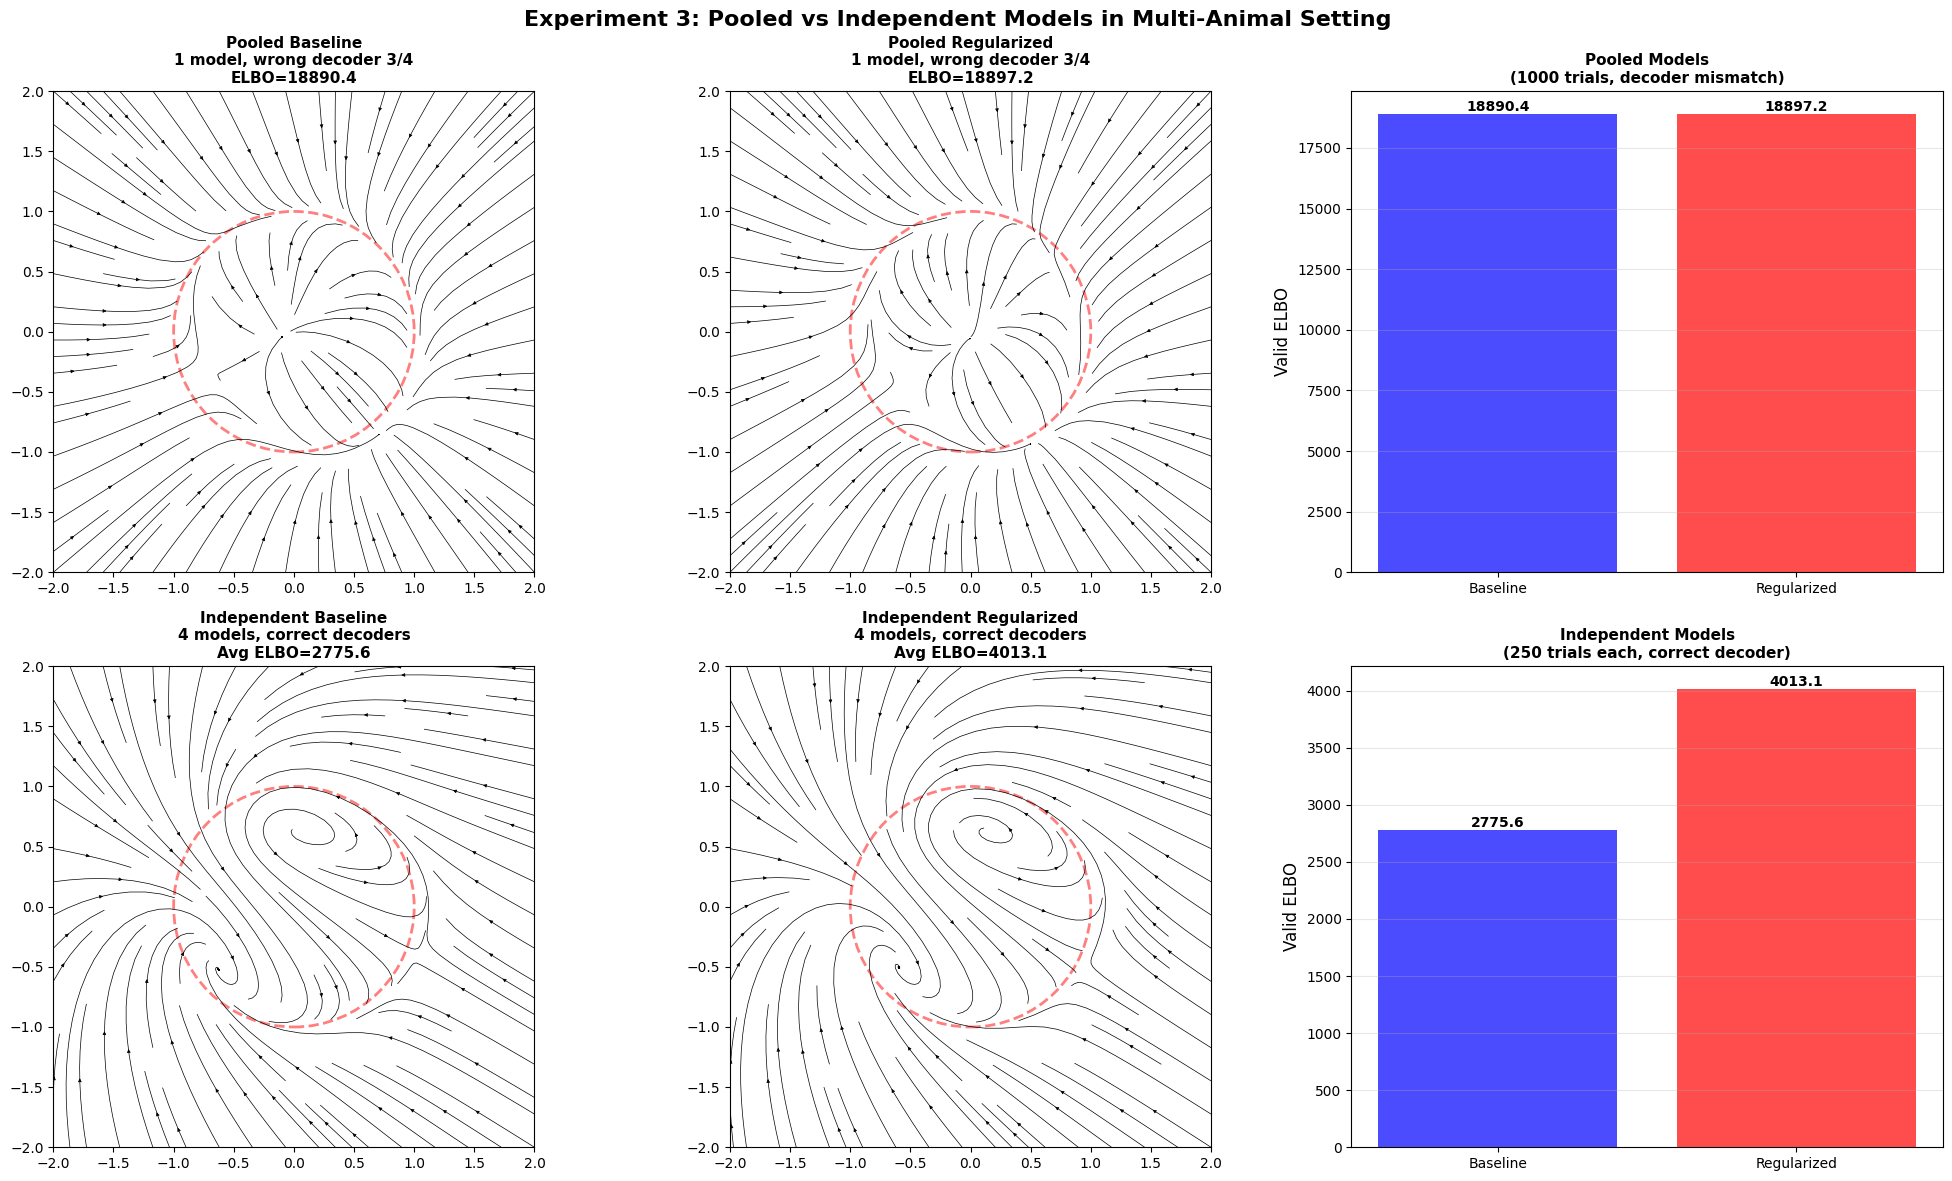


✅ Saved: experiment3_pooled_vs_independent.png


In [52]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Row 1: Pooled models
ax = axes[0, 0]
ssm_exp2_baseline.eval()
plot_utils.plot_two_d_vector_field(ssm_exp2_baseline.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.add_patch(circle)
ax.set_title(f'Pooled Baseline\n1 model, wrong decoder 3/4\nELBO={stats_exp2_baseline["elbo"]:.1f}', 
             fontweight='bold', fontsize=11)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

ax = axes[0, 1]
ssm_exp2_reg.eval()
plot_utils.plot_two_d_vector_field(ssm_exp2_reg.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.add_patch(circle)
ax.set_title(f'Pooled Regularized\n1 model, wrong decoder 3/4\nELBO={stats_exp2_reg["elbo"]:.1f}', 
             fontweight='bold', fontsize=11)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# Pooled comparison
ax = axes[0, 2]
bars = ax.bar(['Baseline', 'Regularized'], 
              [stats_exp2_baseline['elbo'], stats_exp2_reg['elbo']],
              color=['blue', 'red'], alpha=0.7)
ax.set_ylabel('Valid ELBO', fontsize=12)
ax.set_title('Pooled Models\n(1000 trials, decoder mismatch)', fontweight='bold', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# Row 2: Independent models (show first animal as example)
ax = axes[1, 0]
ssm_indep_baseline[3].eval()
plot_utils.plot_two_d_vector_field(ssm_indep_baseline[3].dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.add_patch(circle)
ax.set_title(f'Independent Baseline\n4 models, correct decoders\nAvg ELBO={avg_elbo_indep_baseline:.1f}', 
             fontweight='bold', fontsize=11)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

ax = axes[1, 1]
ssm_indep_reg[3].eval()
plot_utils.plot_two_d_vector_field(ssm_indep_reg[3].dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.add_patch(circle)
ax.set_title(f'Independent Regularized\n4 models, correct decoders\nAvg ELBO={avg_elbo_indep_reg:.1f}', 
             fontweight='bold', fontsize=11)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# Independent comparison
ax = axes[1, 2]
bars = ax.bar(['Baseline', 'Regularized'], 
              [avg_elbo_indep_baseline, avg_elbo_indep_reg],
              color=['blue', 'red'], alpha=0.7)
ax.set_ylabel('Valid ELBO', fontsize=12)
ax.set_title('Independent Models\n(250 trials each, correct decoder)', fontweight='bold', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Experiment 3: Pooled vs Independent Models in Multi-Animal Setting', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('experiment3_pooled_vs_independent.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: experiment3_pooled_vs_independent.png")

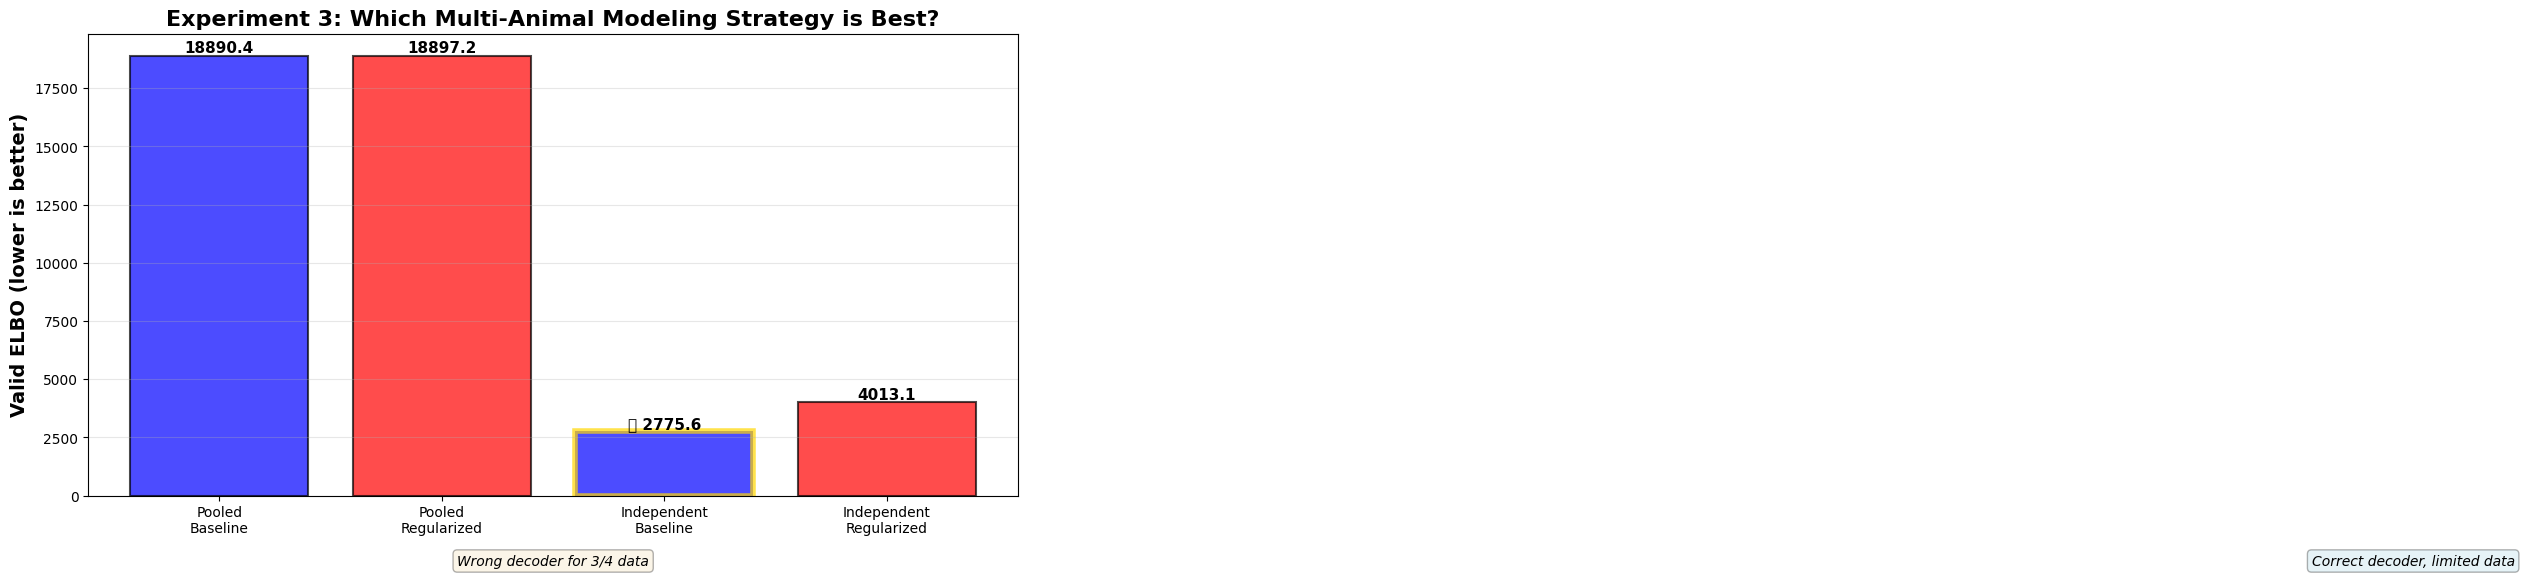


✅ Saved: experiment3_overall_comparison.png


In [47]:
# Overall summary bar chart comparing all strategies
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

strategies = ['Pooled\nBaseline', 'Pooled\nRegularized', 
              'Independent\nBaseline', 'Independent\nRegularized']
elbos = [stats_exp2_baseline['elbo'], stats_exp2_reg['elbo'],
         avg_elbo_indep_baseline, avg_elbo_indep_reg]
colors = ['blue', 'red', 'blue', 'red']

bars = ax.bar(strategies, elbos, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Highlight the best
best_idx = np.argmin(elbos)
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(4)

ax.set_ylabel('Valid ELBO (lower is better)', fontsize=14, fontweight='bold')
ax.set_title('Experiment 3: Which Multi-Animal Modeling Strategy is Best?', 
             fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    label = f'{height:.1f}'
    if i == best_idx:
        label = f'🏆 {label}'
    ax.text(bar.get_x() + bar.get_width()/2., height,
            label, ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add annotations
ax.text(0.5, -0.15, 'Wrong decoder for 3/4 data', ha='center', transform=ax.transAxes,
        fontsize=10, style='italic', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
ax.text(2.5, -0.15, 'Correct decoder, limited data', ha='center', transform=ax.transAxes,
        fontsize=10, style='italic', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.tight_layout()
plt.savefig('experiment3_overall_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: experiment3_overall_comparison.png")

---
# Experiment 4: Different Parent Dynamics

**Key Question**: Can regularization help when data comes from different underlying dynamical systems that all share the same rotational symmetry?

**Setup**:
- 4 different parent dynamics (varying lengthscales/perturbation magnitudes)
- Same decoder (observation function)
- Same total time series length (1000 trials × 75 time bins)
- All share rotational symmetry

**Comparison**:
1. Baseline: Learn from pooled heterogeneous dynamics
2. Regularized: Same but with symmetry regularization

**Hypothesis**: Regularization provides useful inductive bias when dynamics are heterogeneous but share common symmetry

In [53]:
print("\n" + "=" * 60)
print("EXPERIMENT 4: Different Parent Dynamics")
print("=" * 60)

# Create ONE observation matrix (same decoder for all)
C_exp4 = utils.FanInLinear(cfg.n_latents, cfg.n_neurons, device=device).requires_grad_(False)

# Define 4 different parent dynamics with varying parameters
dynamics_params = [
    {'lengthscale': 0.15, 'perturbation_magnitude': 0.10, 'name': 'Fast/Low-pert'},
    {'lengthscale': 0.20, 'perturbation_magnitude': 0.15, 'name': 'Medium/Med-pert'},
    {'lengthscale': 0.25, 'perturbation_magnitude': 0.20, 'name': 'Slow/High-pert'},
    {'lengthscale': 0.30, 'perturbation_magnitude': 0.25, 'name': 'Slowest/Highest-pert'},
]

# Generate data from DIFFERENT parent dynamics
z_all_dynamics = []
y_all_dynamics = []

print(f"\nGenerating data from {len(dynamics_params)} different parent dynamics...")
print(f"Each gets {cfg.n_trials_per_condition} trials")

for i, params in enumerate(dynamics_params):
    torch.manual_seed(SEED + i * 500)  # Different seed for each
    
    dynamics = PerturbedRingAttractorDynamics(
        bin_sz=1e-1,
        lengthscale=params['lengthscale'],
        perturbation_magnitude=params['perturbation_magnitude']
    ).to(device)
    
    # Generate trajectories
    z = utils.sample_gauss_z(dynamics, Q_diag, m_0, Q_0_diag, 
                            cfg.n_trials_per_condition, cfg.n_time_bins)
    y = C_exp4(z) + torch.sqrt(R_diag) * torch.randn(
        (cfg.n_trials_per_condition, cfg.n_time_bins, cfg.n_neurons), device=device)
    
    z_all_dynamics.append(z)
    y_all_dynamics.append(y)
    
    print(f"  Dynamics {i+1} ({params['name']}): {cfg.n_trials_per_condition} trials")
    print(f"    lengthscale={params['lengthscale']:.3f}, pert_mag={params['perturbation_magnitude']:.3f}")

# Pool all data together
z_exp4 = torch.cat(z_all_dynamics, dim=0).detach()
y_exp4 = torch.cat(y_all_dynamics, dim=0).detach()

# Shuffle
torch.manual_seed(SEED)
shuffle_idx = torch.randperm(y_exp4.shape[0])
z_exp4 = z_exp4[shuffle_idx]
y_exp4 = y_exp4[shuffle_idx]

n_train_exp4 = int(cfg.train_split * y_exp4.shape[0])
y_train_exp4 = y_exp4[:n_train_exp4]
y_valid_exp4 = y_exp4[n_train_exp4:]

print(f"\n✅ Experiment 4 data ready:")
print(f"   Total: {y_exp4.shape[0]} trials (pooled from {len(dynamics_params)} dynamics)")
print(f"   Train: {y_train_exp4.shape[0]} trials")
print(f"   Valid: {y_valid_exp4.shape[0]} trials")
print(f"   Same decoder, different parent dynamics!")


EXPERIMENT 4: Different Parent Dynamics

Generating data from 4 different parent dynamics...
Each gets 250 trials
  Dynamics 1 (Fast/Low-pert): 250 trials
    lengthscale=0.150, pert_mag=0.100
  Dynamics 2 (Medium/Med-pert): 250 trials
    lengthscale=0.200, pert_mag=0.150
  Dynamics 3 (Slow/High-pert): 250 trials
    lengthscale=0.250, pert_mag=0.200
  Dynamics 4 (Slowest/Highest-pert): 250 trials
    lengthscale=0.300, pert_mag=0.250

✅ Experiment 4 data ready:
   Total: 1000 trials (pooled from 4 dynamics)
   Train: 800 trials
   Valid: 200 trials
   Same decoder, different parent dynamics!


In [54]:
print("\n" + "=" * 60)
print("Training Experiment 4: Heterogeneous Dynamics")
print("=" * 60)

# Baseline
torch.manual_seed(SEED)
ssm_exp4_baseline = create_ssm(lambda_lie=0.0, C_matrix=C_exp4)
stats_exp4_baseline = train_model(ssm_exp4_baseline, y_train_exp4, y_valid_exp4, "Exp4 Baseline")

# Regularized
torch.manual_seed(SEED)
ssm_exp4_reg = create_ssm(lambda_lie=cfg.lambda_lie, C_matrix=C_exp4)
stats_exp4_reg = train_model(ssm_exp4_reg, y_train_exp4, y_valid_exp4, "Exp4 Regularized")

print(f"\n📊 Experiment 4 Results:")
print(f"   Baseline:")
print(f"     ELBO: {stats_exp4_baseline['elbo']:.3f}")
print(f"     Lie Loss: {stats_exp4_baseline['lie_loss']:.4f}")
print(f"   Regularized:")
print(f"     ELBO: {stats_exp4_reg['elbo']:.3f}")
print(f"     Lie Loss: {stats_exp4_reg['lie_loss']:.4f}")
print(f"   Improvement: {stats_exp4_baseline['elbo'] - stats_exp4_reg['elbo']:.3f}")

if stats_exp4_reg['elbo'] < stats_exp4_baseline['elbo']:
    print(f"\n   ✅ Regularization helps with heterogeneous dynamics!")
else:
    print(f"\n   ❌ Regularization doesn't help (ELBO worse by {stats_exp4_reg['elbo'] - stats_exp4_baseline['elbo']:.3f})")


Training Experiment 4: Heterogeneous Dynamics
Training Exp4 Baseline...
  Epoch 5: Valid ELBO = 10695.872, Patience = 0/7
  Epoch 10: Valid ELBO = 2580.116, Patience = 0/7
  Epoch 15: Valid ELBO = 2435.989, Patience = 0/7
  Epoch 20: Valid ELBO = 2380.872, Patience = 0/7
  Epoch 25: Valid ELBO = 2340.723, Patience = 0/7
  Epoch 30: Valid ELBO = 2316.203, Patience = 0/7
  Final Valid ELBO: 2316.667, Lie Loss: 0.0000
Training Exp4 Regularized...
  Epoch 5: Valid ELBO = 11410.756, Patience = 0/7
  Epoch 10: Valid ELBO = 2568.607, Patience = 0/7
  Epoch 15: Valid ELBO = 2428.219, Patience = 0/7
  Epoch 20: Valid ELBO = 2369.551, Patience = 0/7
  Epoch 25: Valid ELBO = 2332.583, Patience = 0/7
  Epoch 30: Valid ELBO = 2317.548, Patience = 1/7
  Final Valid ELBO: 2316.534, Lie Loss: 56.9678

📊 Experiment 4 Results:
   Baseline:
     ELBO: 2316.667
     Lie Loss: 0.0000
   Regularized:
     ELBO: 2316.534
     Lie Loss: 56.9678
   Improvement: 0.133

   ✅ Regularization helps with heterogene

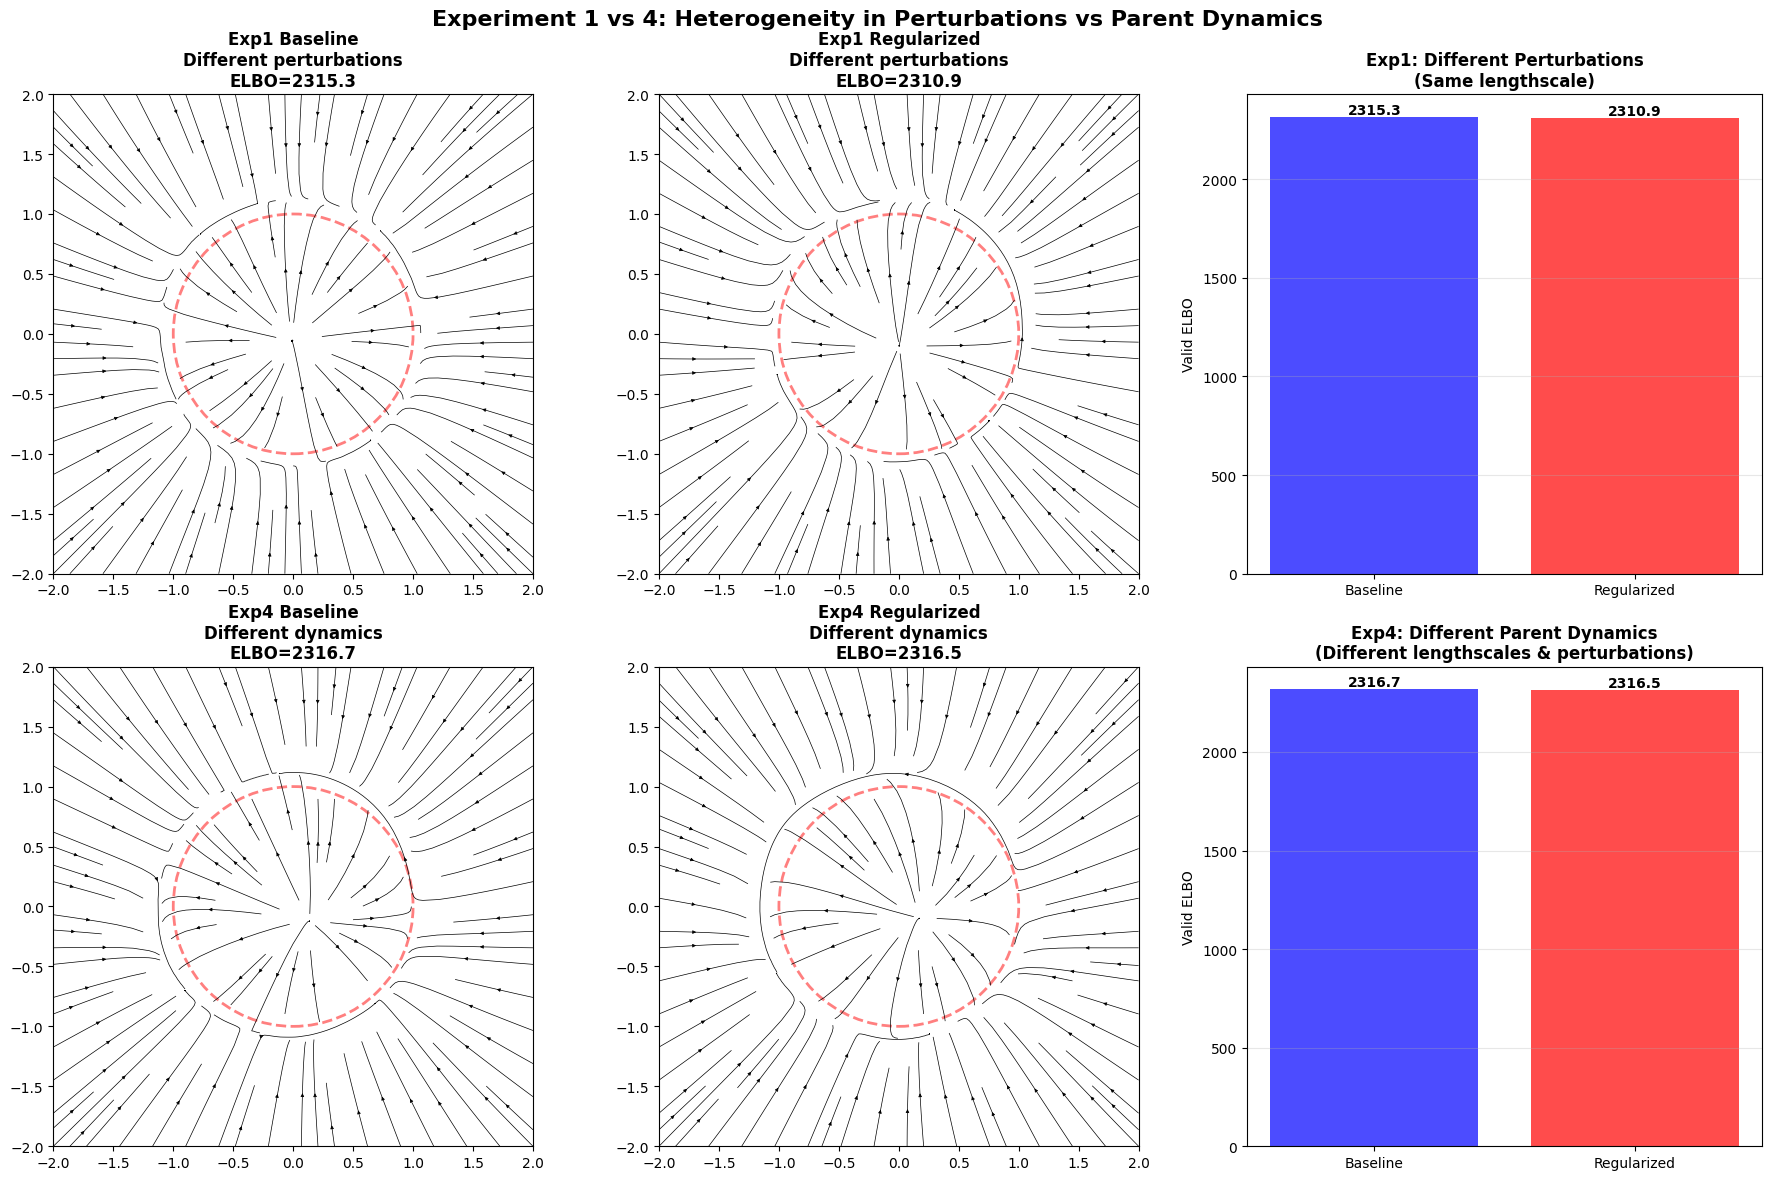


✅ Saved: experiment4_heterogeneous_dynamics.png


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Exp 1 (different perturbations)
ax = axes[0, 0]
ssm_exp1_baseline.eval()
plot_utils.plot_two_d_vector_field(ssm_exp1_baseline.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.add_patch(circle)
ax.set_title(f'Exp1 Baseline\nDifferent perturbations\nELBO={stats_exp1_baseline["elbo"]:.1f}', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

ax = axes[0, 1]
ssm_exp1_reg.eval()
plot_utils.plot_two_d_vector_field(ssm_exp1_reg.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.add_patch(circle)
ax.set_title(f'Exp1 Regularized\nDifferent perturbations\nELBO={stats_exp1_reg["elbo"]:.1f}', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# Exp 1 comparison
ax = axes[0, 2]
bars = ax.bar(['Baseline', 'Regularized'], [stats_exp1_baseline['elbo'], stats_exp1_reg['elbo']],
              color=['blue', 'red'], alpha=0.7)
ax.set_ylabel('Valid ELBO')
ax.set_title('Exp1: Different Perturbations\n(Same lengthscale)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# Row 2: Exp 4 (different parent dynamics)
ax = axes[1, 0]
ssm_exp4_baseline.eval()
plot_utils.plot_two_d_vector_field(ssm_exp4_baseline.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.add_patch(circle)
ax.set_title(f'Exp4 Baseline\nDifferent dynamics\nELBO={stats_exp4_baseline["elbo"]:.1f}', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

ax = axes[1, 1]
ssm_exp4_reg.eval()
plot_utils.plot_two_d_vector_field(ssm_exp4_reg.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.add_patch(circle)
ax.set_title(f'Exp4 Regularized\nDifferent dynamics\nELBO={stats_exp4_reg["elbo"]:.1f}', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# Exp 4 comparison
ax = axes[1, 2]
bars = ax.bar(['Baseline', 'Regularized'], [stats_exp4_baseline['elbo'], stats_exp4_reg['elbo']],
              color=['blue', 'red'], alpha=0.7)
ax.set_ylabel('Valid ELBO')
ax.set_title('Exp4: Different Parent Dynamics\n(Different lengthscales & perturbations)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Experiment 1 vs 4: Heterogeneity in Perturbations vs Parent Dynamics', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('experiment4_heterogeneous_dynamics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: experiment4_heterogeneous_dynamics.png")

In [56]:
print("\n" + "=" * 70)
print("EXPERIMENT 4 vs 1: COMPARISON")
print("=" * 70)

print("\n📊 Both experiments: Same decoder, 1000 trials, but different heterogeneity")
print("\n🔬 Experiment 1: Different PERTURBATIONS (same lengthscale)")
print(f"   Baseline:    {stats_exp1_baseline['elbo']:.3f}")
print(f"   Regularized: {stats_exp1_reg['elbo']:.3f}")
print(f"   Δ ELBO:      {stats_exp1_baseline['elbo'] - stats_exp1_reg['elbo']:.3f}")

print("\n🔬 Experiment 4: Different PARENT DYNAMICS (different lengthscales & perturbations)")
print(f"   Baseline:    {stats_exp4_baseline['elbo']:.3f}")
print(f"   Regularized: {stats_exp4_reg['elbo']:.3f}")
print(f"   Δ ELBO:      {stats_exp4_baseline['elbo'] - stats_exp4_reg['elbo']:.3f}")

print("\n💡 Key Insights:")

# Compare improvements
exp1_improvement = stats_exp1_baseline['elbo'] - stats_exp1_reg['elbo']
exp4_improvement = stats_exp4_baseline['elbo'] - stats_exp4_reg['elbo']

if exp1_improvement > 0 and exp4_improvement > 0:
    print("   ✅ Regularization helps in BOTH cases")
    if exp4_improvement > exp1_improvement:
        print(f"   → MORE helpful with heterogeneous dynamics (+{exp4_improvement:.1f} vs +{exp1_improvement:.1f})")
    else:
        print(f"   → LESS helpful with heterogeneous dynamics (+{exp4_improvement:.1f} vs +{exp1_improvement:.1f})")
elif exp1_improvement > 0 and exp4_improvement <= 0:
    print("   ⚠️  Regularization helps with perturbation heterogeneity")
    print("   ❌ But HURTS with dynamics heterogeneity")
elif exp1_improvement <= 0 and exp4_improvement > 0:
    print("   ❌ Regularization doesn't help with perturbation heterogeneity")
    print("   ✅ But HELPS with dynamics heterogeneity")
else:
    print("   ❌ Regularization doesn't help in either case")

print("\n" + "=" * 70)


EXPERIMENT 4 vs 1: COMPARISON

📊 Both experiments: Same decoder, 1000 trials, but different heterogeneity

🔬 Experiment 1: Different PERTURBATIONS (same lengthscale)
   Baseline:    2315.338
   Regularized: 2310.906
   Δ ELBO:      4.432

🔬 Experiment 4: Different PARENT DYNAMICS (different lengthscales & perturbations)
   Baseline:    2316.667
   Regularized: 2316.534
   Δ ELBO:      0.133

💡 Key Insights:
   ✅ Regularization helps in BOTH cases
   → LESS helpful with heterogeneous dynamics (+0.1 vs +4.4)



In [57]:
# Store all stats in a comprehensive dictionary
print("\n" + "=" * 70)
print("FINAL SUMMARY: All Experiments")
print("=" * 70)

all_stats = {
    'exp1': {
        'baseline': stats_exp1_baseline,
        'regularized': stats_exp1_reg,
        'description': f'{cfg.n_perturbations} perturbation distributions, same decoder'
    },
    'exp2': {
        'pooled_baseline': stats_exp2_baseline,
        'pooled_regularized': stats_exp2_reg,
        'description': f'{cfg.n_animals} animals, pooled data, wrong decoder for 3/4'
    },
    'exp3': {
        'pooled_baseline': stats_exp2_baseline,
        'pooled_regularized': stats_exp2_reg,
        'independent_baseline': {
            'avg_elbo': avg_elbo_indep_baseline,
            'avg_lie_loss': avg_lie_indep_baseline,
            'individual_stats': stats_indep_baseline
        },
        'independent_regularized': {
            'avg_elbo': avg_elbo_indep_reg,
            'avg_lie_loss': avg_lie_indep_reg,
            'individual_stats': stats_indep_reg
        },
        'description': 'Pooled vs Independent models comparison'
    }
}

print("\n📊 Experiment 1: Multiple Perturbation Distributions")
print(f"   {all_stats['exp1']['description']}")
print(f"   Baseline ELBO:    {all_stats['exp1']['baseline']['elbo']:.3f}")
print(f"   Regularized ELBO: {all_stats['exp1']['regularized']['elbo']:.3f}")
print(f"   Improvement:      {all_stats['exp1']['baseline']['elbo'] - all_stats['exp1']['regularized']['elbo']:.3f}")

print("\n📊 Experiment 2: Multi-Animal Pooled Models")
print(f"   {all_stats['exp2']['description']}")
print(f"   Baseline ELBO:    {all_stats['exp2']['pooled_baseline']['elbo']:.3f}")
print(f"   Regularized ELBO: {all_stats['exp2']['pooled_regularized']['elbo']:.3f}")
print(f"   Improvement:      {all_stats['exp2']['pooled_baseline']['elbo'] - all_stats['exp2']['pooled_regularized']['elbo']:.3f}")

print("\n📊 Experiment 3: Pooled vs Independent Models")
print(f"   {all_stats['exp3']['description']}")
print(f"   Pooled Baseline:        {all_stats['exp3']['pooled_baseline']['elbo']:.3f}")
print(f"   Pooled Regularized:     {all_stats['exp3']['pooled_regularized']['elbo']:.3f}")
print(f"   Independent Baseline:   {all_stats['exp3']['independent_baseline']['avg_elbo']:.3f}")
print(f"   Independent Regularized: {all_stats['exp3']['independent_regularized']['avg_elbo']:.3f}")

best_exp3 = min([
    ('Pooled Baseline', all_stats['exp3']['pooled_baseline']['elbo']),
    ('Pooled Regularized', all_stats['exp3']['pooled_regularized']['elbo']),
    ('Independent Baseline', all_stats['exp3']['independent_baseline']['avg_elbo']),
    ('Independent Regularized', all_stats['exp3']['independent_regularized']['avg_elbo'])
], key=lambda x: x[1])

print(f"\n   🏆 Best strategy: {best_exp3[0]} (ELBO = {best_exp3[1]:.3f})")

print("\n✅ All stats stored in 'all_stats' dictionary")
print("=" * 70)


FINAL SUMMARY: All Experiments

📊 Experiment 1: Multiple Perturbation Distributions
   4 perturbation distributions, same decoder
   Baseline ELBO:    2315.338
   Regularized ELBO: 2310.906
   Improvement:      4.432

📊 Experiment 2: Multi-Animal Pooled Models
   4 animals, pooled data, wrong decoder for 3/4
   Baseline ELBO:    18890.355
   Regularized ELBO: 18897.189
   Improvement:      -6.834

📊 Experiment 3: Pooled vs Independent Models
   Pooled vs Independent models comparison
   Pooled Baseline:        18890.355
   Pooled Regularized:     18897.189
   Independent Baseline:   2775.590
   Independent Regularized: 4013.122

   🏆 Best strategy: Independent Baseline (ELBO = 2775.590)

✅ All stats stored in 'all_stats' dictionary
